# Statistics & Econometrics
# Assignment 3: Hypothesis testing & regression

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('darkgrid')
%matplotlib inline

import plotly
plotly.tools.set_credentials_file(username='', api_key='')
import plotly.offline as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

import warnings
warnings.filterwarnings('ignore')

### Problem 3. Hypothesis testing

### Task 1. The law of large numbers

In [4]:
# defining sample sizes
alpha = 0.05
mean = 1
std = 1
sample_sizes = np.linspace(10, 100000, 1000, dtype=np.int32)
    
# getting statistics and confidence margins for empirical distributions
moments = {'mean': [], 'std': []}
bounds = {'mean': [], 'std': []}
for sample_size in sample_sizes:
    # sampling
    sample = np.random.normal(mean, std, sample_size)
    
    # calculating statistics
    moments['mean'].append(sample.mean())
    moments['std'].append(sample.std(ddof=1))
    
    # finding confidence interval for mean
    z_critical = stats.t.ppf(df=sample_size - 1, q=1 - alpha/2) 
    mean_margin = z_critical * (sample.std(ddof=1)/math.sqrt(sample_size))
    mean_bounds = [sample.mean() - mean_margin, sample.mean() + mean_margin]
    mean_bounds = np.array(mean_bounds)
    bounds['mean'].append(mean_bounds)
    
    # finding confidence interval for std
    z_critical_right = stats.chi2.ppf(1 - alpha/2, df=sample_size - 1)
    z_critical_left = stats.chi2.ppf(alpha/2, df=sample_size - 1)
    right_bound = np.sqrt(sample_size - 1)*sample.std(ddof=1) / np.sqrt(z_critical_right)
    left_bound = np.sqrt(sample_size - 1)*sample.std(ddof=1) / np.sqrt(z_critical_left)
    std_bounds = [left_bound, right_bound]
    std_bounds = np.array(std_bounds)
    bounds['std'].append(std_bounds)

    
moments['mean'] = np.array(moments['mean'])
moments['std'] = np.array(moments['std'])
bounds['mean'] = np.array(bounds['mean'])
bounds['std'] = np.array(bounds['std'])

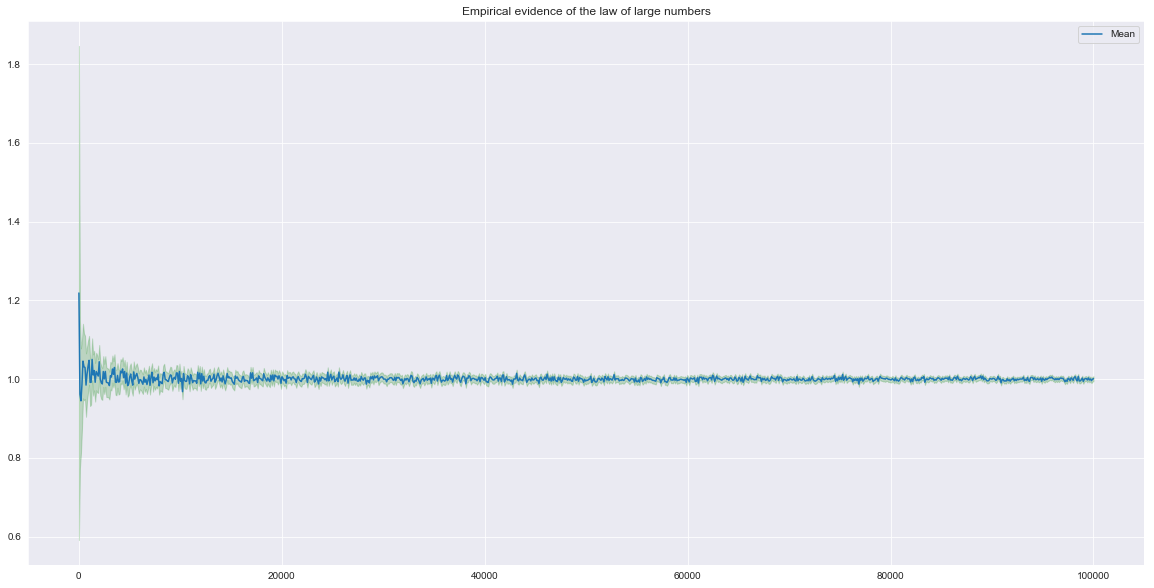

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Empirical evidence of the law of large numbers')
ax.fill_between(sample_sizes, bounds['mean'][:, 0], bounds['mean'][:, 1], alpha=0.2, color='green')
_ = sb.lineplot(sample_sizes, moments['mean'], label='Mean')


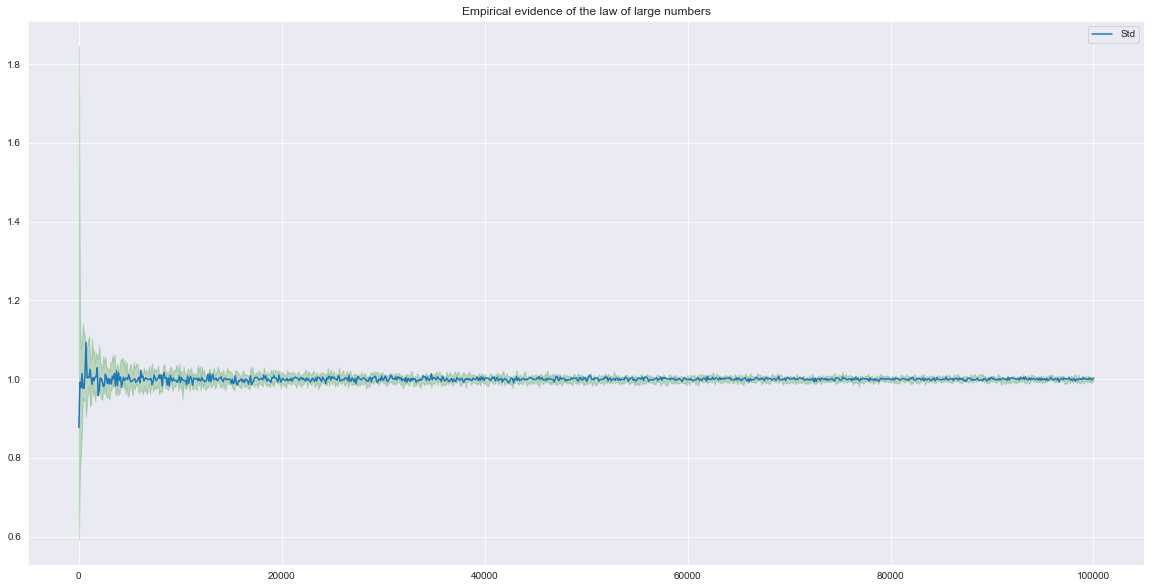

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Empirical evidence of the law of large numbers')
ax.fill_between(sample_sizes, bounds['mean'][:, 0], bounds['mean'][:, 1], alpha=0.2, color='green')
_ = sb.lineplot(sample_sizes, moments['std'], label='Std')

> <font size=3> We see that results obtained from the trials become сloser to the real value as a number of the trials grows. Also, we see that confidence intervals shrink too. In simple words, CI means that the true value of our statistic lies in the given interval with some level of confidence (in our case - 0.95)
   <font>

> <font size=3> Now let's try to estimate sample size such that the margin of error won't exceed 1% (I'll treat it as 0.01 because it's not clear what stands behind this percentage). <br><br>
    We know that in general CI for the mean with unknown variance looks like: <br><br>
    <center>${[\overline x - t_{n-1, {1 - \frac \alpha 2}}\frac S {\sqrt n}, \overline x + t_{n-1, {1 - \frac \alpha 2}}\frac S {\sqrt n}}]$,</center> <br>
    but we can't use this formula because we don't actually have the sample to compute sample variance ${S}$ and also we can't find the value: <br><br><center>${t_{n-1, {1 - \frac \alpha 2}}}$,</center><br> because it needs sample size. <br><br>
    I searched a lot about how to solve this problem and found out that we can try to estimate $\sigma$ prior to our experiment (or for example find value of the variance from the similar study), so then we can estimate needed sample size assuming that we know actual variance (in our case we can simply take $\sigma$ = 1): <br><br><center>${[\overline x - z_{1 - \frac \alpha 2} \frac \sigma {\sqrt n}, \overline x + z_{1 - \frac \alpha 2} \frac \sigma {\sqrt n}}]$</center><br>
    <center>then</center><br>
    <center>${z_{1 - \frac \alpha 2} \frac \sigma {\sqrt n} = 0.01 \implies n =  (\frac {z_{1 - \frac \alpha 2} \sigma}  {0.01})^2}$</center>
  <font>

In [7]:
margin = 0.01
sample_size = (stats.norm.ppf(q = 1 - alpha/2)*std/margin)**2
print('Needed sample size: {:.0f}'.format(sample_size))

Needed sample size: 38415


### Task 2. Likelihood estimation

### (a)

> <font size=3>
    Let ${x_1, ..., x_n}$ be a given sample. We assume that it stems from a t-distribution with an unknown number of degrees of freedom and we want to estimate this unknown parameter with a help of likelihood function.
    <br>
    <br>
    Let's recall what likelihood function looks like: <br><br>
    <center>${L(x_1, ..., x_n; \theta) = \prod f(x_i)}$, where ${f}$ - density function. </center>
    <br>
    <br>
    Now we need to recall t-distribution density function: <br><br>
    <center>${f(x) = \frac {\Gamma(\frac {\omega + 1} {2})} {\sqrt{\pi \omega}\Gamma(\frac \omega 2)} (1 + \frac {x^2} \omega)^{\frac {\omega + 1} {2}}}$ </center>
    <br>
    <br>
    So likelihood function will look as follows: <br><br>
    <center> ${L(x_1, ..., x_n; \theta) = \prod \frac {\Gamma(\frac {\omega + 1} {2})} {\sqrt{\pi \omega}\Gamma(\frac \omega 2)} (1 + \frac {x_i^2} \omega)^{\frac {\omega + 1} {2}}}$ </center>
    <br>
    <br>
    I will not simplify this function, because actually, it will look even more complicated (polynomial with 2n - 1 degree). Moreover, we can't find a closed form for ML estimator, so it's unnecessary to expand this formula. Instead, we will find ML estimator via numerical optimization.
  <font>

### (b)

In [13]:
# simulating data
sample = np.random.standard_t(df=5, size=100)

# defining likelihood
def likelihood(data, df):
    return -np.sum(np.array(list(map(lambda x: np.log(stats.t.pdf(x, df)), data))))

# optimizing likelihood with help of scipy optimizer
res = scipy.optimize.minimize(lambda x: likelihood(sample, x), x0=12., constraints={'type': 'ineq', 'fun': lambda x: x})
print('Optimal value: {}'.format(res['x'][0]))

Optimal value: 5.346282981970513


> <font size=3>
    Also, we can inspect the likelihood function visually. 
   <font>

In [14]:
values = np.linspace(3, 15, 15)
res = [likelihood(sample, df=val) for val in values]

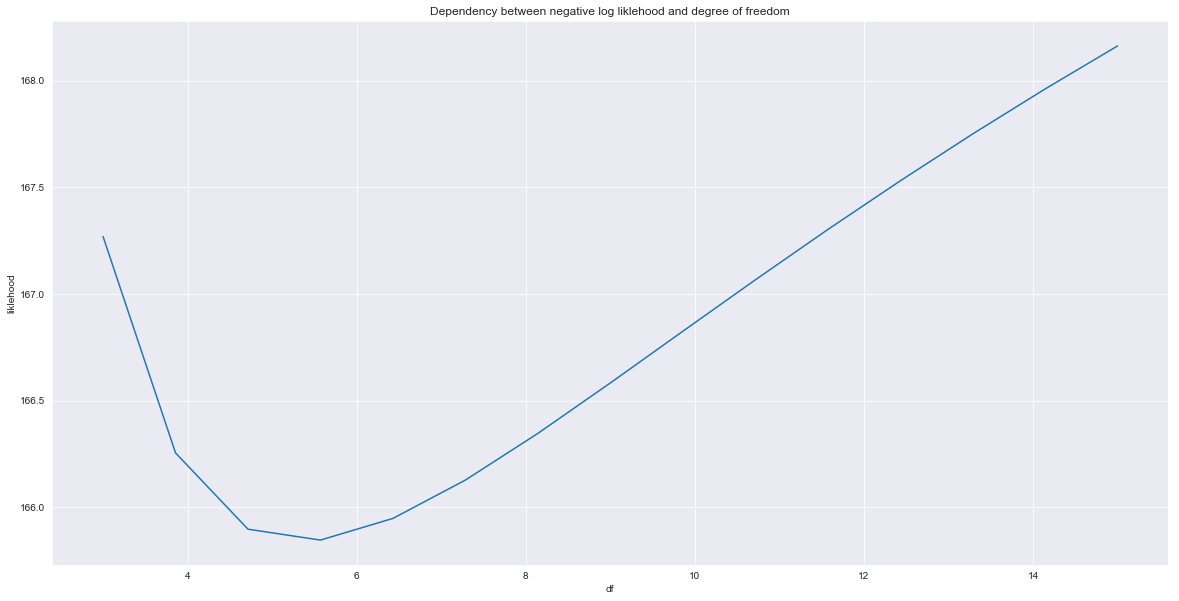

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Dependency between negative log liklehood and degree of freedom')
ax.set_xlabel('df')
ax.set_ylabel('liklehood')
_ = sb.lineplot(values,res)

### (c)

> <font size=3>
    But what we can do when the real sample doesn't have zero mean and variance df/(df-2). We can add two new parameters ($\mu, \sigma.$) Then we can simply shift and scale our random variable as follows: <br><br><center>$X^* = \mu + \sigma X$ </center> <br><br>
Then we can easily obtain density function for the new random variable (because we know the general rule for the transformation of continuous random variables): <br><br>
    <center>$f^*(x) = \frac 1 {\sigma} f(\frac {x - \mu} \sigma)$</center> <br><br>
    Now we can optimize the likelihood function with respect to df and this two new parameters as we did previously. Also it worth to note that transformed variable has following moments: <br><br>
    <center>$\mathbb{E}X^* = \mu, \mathbb{D}X^* = \sigma^2 \frac {df} {df-2}$</center>
  <font>

In [20]:
df = 5
mean = 10
variance = 3

# simulating data
sample = np.random.standard_t(df=df, size=100)
sample = mean + sample*variance

# defining likelihood
def likelihood(data, params):
    return -np.sum(np.array(list(map(lambda x: np.log(1/params[1]*stats.t.pdf((x - params[0])/params[1], params[2])), data))))

# optimizing likelihood with help of scipy optimizer
res = scipy.optimize.minimize(lambda x: likelihood(sample, x), x0=[12., 12., 12.], constraints=[{'type': 'ineq', 'fun': lambda x: x[1]},
                                                                                                {'type': 'ineq', 'fun': lambda x: x[2]}])
print('Optimal value for mean: {}'.format(res['x'][0]))
print('Optimal value for variance: {}'.format(res['x'][1]))
print('Optimal value for df: {}'.format(res['x'][2]))

Optimal value for mean: 9.888493429882496
Optimal value for variance: 3.309108225248453
Optimal value for df: 4.6278829018197145


### Task 3. Two-sided test for the mean

### (a)

> <font size=3>
    The idea of hypothesis testing is pretty simple. We theoretically derive some random variable with a known distribution, then we calculate the value of this statistic based on our data and check where this value lies. If it lies in tails (the size of the tails are controlled by parameter $\alpha$ which is called the level of significance), then we can reject the null hypothesis. Otherwise, we say that we can't reject the null hypothesis. <br><br>
    I won't write the look of statistic for the two-sided test for the mean, because we have it in the slide, and also I wrote it in the code.
  <font>

In [21]:
# simulating data
assumption = 500
alpha = 0.04
sample = np.random.normal(loc=500, scale=np.sqrt(50), size=100)

# moments
sampled_mean = sample.mean()
sampled_std = sample.std(ddof=1)
sample_size = 100

test_statistic = np.sqrt(sample_size)*(sampled_mean - assumption)/sampled_std
left_bound = -stats.t.ppf(1 - alpha/2, df=sample_size - 1)
right_bound = stats.t.ppf(1 - alpha/2, df=sample_size - 1)
print('Rejection area is (-inf, {:.2f}) U ({:.2f}, +inf) and test statistic equals to {:.2f}'.format(left_bound, 
                                                                                               right_bound,
                                                                                               test_statistic))

Rejection area is (-inf, -2.08) U (2.08, +inf) and test statistic equals to -1.70


> <font size=3>
    We see that our statistics lies outside of the rejection area or in other words tails of the distribution, so we can't reject the null hypothesis that $\mu = 500$ (but it also doesn't mean that $\mu$ indeed equals to 500).<br><br>
    <font>

### (b)

> <font size=3>
Also, we have another more convenient method for hypothesis testing via p-value. The p-value is the $\alpha$ for which null hypothesis is still not rejected. And it means that the smaller p-value is, the more evidence that the null hypothesis isn't correct.
<font>

In [22]:
p_value = (1 - stats.t.cdf(test_statistic, df=sample_size - 1))*2 if test_statistic > 0 else stats.t.cdf(test_statistic, df=sample_size-1)*2
print('My own implementation the of p-value computation: {:.2f}'.format(p_value))

p_value = stats.ttest_1samp(sample, 500)[1]
print('p-value from the Stats package: {:.2f}'.format(p_value))

check = p_value < alpha
if check:
    print('p-value is smaller than the level of significance, so we can reject the null hypothesis')
else:
    print('p-value is bigger than the level of significance, so we can\'t reject the null hypothesis')


My own implementation the of p-value computation: 0.09
p-value from the Stats package: 0.09
p-value is bigger than the level of significance, so we can't reject the null hypothesis


### (c)

In [23]:
num_samples = 1000
sample_size = 100
mean = 500
std = np.sqrt(50)
alpha = 0.04
indicators = []

for i in range(num_samples):
    sample = np.random.normal(loc=mean, scale=std, size=sample_size)
    
    test_statistic = np.sqrt(sample_size)*(sample.mean() - assumption)/sample.std(ddof=1)
    left_bound = -stats.t.ppf(1 - alpha/2, df=sample_size - 1)
    right_bound = stats.t.ppf(1 - alpha/2, df=sample_size - 1)
    
    p = 0 if test_statistic < right_bound and test_statistic > left_bound else 1
    indicators.append(p)

indicators = np.array(indicators)
indicators.mean()

0.041

> <font size=3> I expected that the value of the theoretical and empirical level of significance would be pretty similar and that's what I got. It's pretty obvious because we have an assumption that our data is normally distributed.
  <font>

### (d)

In [26]:
num_samples = 1000
sample_size = 100
mean = 500
std = np.sqrt(50)
alpha = 0.04
indicators = []

for i in range(num_samples):
    sample = mean + np.random.standard_t(df=3, size=sample_size)
    
    test_statistic = np.sqrt(sample_size)*(sample.mean() - assumption)/sample.std(ddof=1)
    left_bound = -stats.t.ppf(1 - alpha/2, df=sample_size - 1)
    right_bound = stats.t.ppf(1 - alpha/2, df=sample_size - 1)
    
    p = 0 if test_statistic < right_bound and test_statistic > left_bound else 1
    indicators.append(p)

indicators = np.array(indicators)
indicators.mean()

0.028

> <font size=3>Normal distribution and t-distribution (in this case shifted t-distribution) are pretty similar, but still not the same, so there theoretical and empirical level of significance differ more than in the previous case.
  <font>

### (e)

In [27]:
num_samples = 1000
sample_size = 100
dfs = np.arange(2, 50, 1)
alpha = 0.025

alphas_hat = []
for step, df in enumerate(dfs):
    indicators = []
    for i in range(num_samples):
        sample = np.random.standard_t(df=df, size=sample_size)
        p_value = stats.kstest(sample, 'norm')[1]
        p = 1 if alpha > p_value else 0
        indicators.append(p)
    indicators = np.array(indicators)
    alpha_hat = indicators.mean()
    alphas_hat.append(alpha_hat)
    
    print('Progress: {:.1f}%'.format((step / dfs.shape[0])*100), end='\r')
        

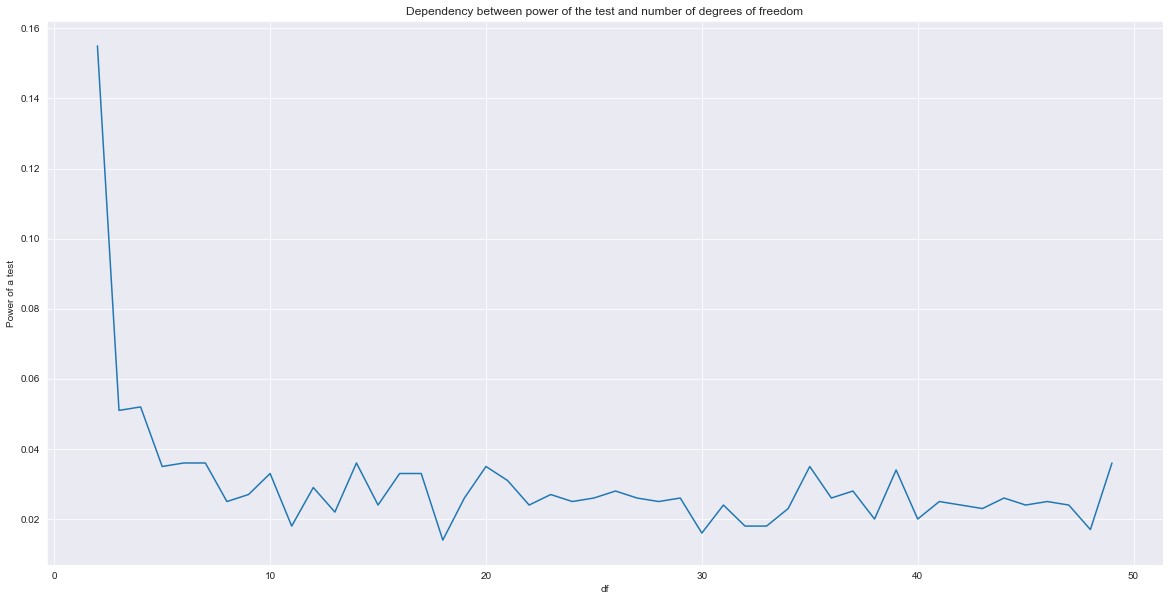

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Dependency between power of the test and number of degrees of freedom')
ax.set_xlabel('df')
ax.set_ylabel('Power of a test')
_ = sb.lineplot(dfs, alphas_hat)

> <font size=3>
    We use the Kolmogorov-Smirnov test to check whether our data is normally distributed. <br><br>
    Power of the test is the probability of rejecting the null hypothesis (in our case that data is normally distributed) if the alternative hypothesis is true. Obviously, in our case alternative hypothesis is always true (because our data is sampled from t-distribution), so the value that we calculated and plotted is the empirical power of the test. <br><br> 
    We know that t-distribution converges to the normal as df tends to infinity. And we see from the plot that as t-distribution becomes more like normal the power of the test becomes smaller, which is obvious.
  <font>

### Problem 4: Linear regression analysis

### Task 1: Data exploration

In [110]:
data = pd.read_csv('../data/telco.txt', sep='\t')

In [66]:
data.head()

tenure  age    marital  address  income                            ed  \
1      13   44    Married        9      64                College degree   
2      11   33    Married        7     136     Post-undergraduate degree   
3      68   52    Married       24     116  Did not complete high school   
4      33   33  Unmarried       12      33            High school degree   
5      23   30    Married        9      30  Did not complete high school   

   employ retire  gender  longmon  wiremon churn  
1       5     No    Male     3.70      0.0   Yes  
2       5     No    Male     4.40     35.7   Yes  
3      29     No  Female    18.15      0.0    No  
4       0     No  Female     9.45      0.0   Yes  
5       2     No    Male     6.30      0.0    No

> <font size=3> We see that our data contain a couple of non-numeric features: marital status, education, gender, retire and churn. It's easy to deal with marital status, gender, retire and churn as we can simply create a binary feature. But it's a bit more complicated in the case of education. We can try different approaches:<br><br>
1) Maybe for our case, it's important just to know whether our client has at least some level of education, so we can again create a binary feature (didn't complete high school/complete high school), but in this case, we'll miss some potentially useful information.<br><br>
2) Another way to treat this feature is to create dummy variables, so for each possible value, we'll have separate binary features. In our case, there are five different categories, which mean we'll have five different binary variables. But it's a bad solution because it's not possible to become a college student unless you are a high school graduate, the same is with post-undergrad and a college degree. So there is some sort of order, which is lost if we use dummies. <br><br>
3) So the best option is to treat this feature as ordinal and assign to each category some number so that there will be some order dependency. <br><br>
Also, I've found out that there is no description for 'employ' variable. Without description, it's hard to understand whether it's a numeric, categorical or ordinal feature (it has only 46 unique values). So that why I'll omit it from the following analysis. It's always better to fully understand your data.
  <font>

In [111]:
ed2num = {
    'Did not complete high school' : 0,
    'High school degree' : 1,
    'Some college' : 2,
    'College degree' : 3,
    'Post-undergraduate degree' : 4
}

data['ed_level'] = data['ed'].apply(lambda ed: ed2num[ed])
data['is_married'] = data['marital'].apply(lambda status: 1 if status == 'Married' else 0)
data['is_retired'] = data['retire'].apply(lambda status: 1 if status == 'Yes' else 0)
data['is_male'] = data['gender'].apply(lambda gender: 1 if gender == 'Male' else 0)
data['is_churned'] = data['churn'].apply(lambda status: 1 if status == 'Yes' else 0)
data = data.drop(columns=['ed', 'marital', 'retire', 'gender', 'churn', 'employ'])

In [68]:
data.head()

tenure  age  address  income  longmon  wiremon  ed_level  is_married  \
1      13   44        9      64     3.70      0.0         3           1   
2      11   33        7     136     4.40     35.7         4           1   
3      68   52       24     116    18.15      0.0         0           1   
4      33   33       12      33     9.45      0.0         1           0   
5      23   30        9      30     6.30      0.0         0           1   

   is_retired  is_male  is_churned  
1           0        1           1  
2           0        1           1  
3           0        0           0  
4           0        0           1  
5           0        1           0

### Task 2: Scaling and variable selection

In [112]:
cols = ['age', 'income', 'longmon', 'ed_level']
for col in cols:
    data[col] = np.log(data[col].values + 0.001) # adding some small value for numerical stability

> <font size=3> Numeric variables such as address, income, and age are skewed, so we can apply log transformation to make their distribution closer to the normal distribution. The same is about target variable longmon, but we need to keep in mind that the inference step will be different in this case.
  <font>

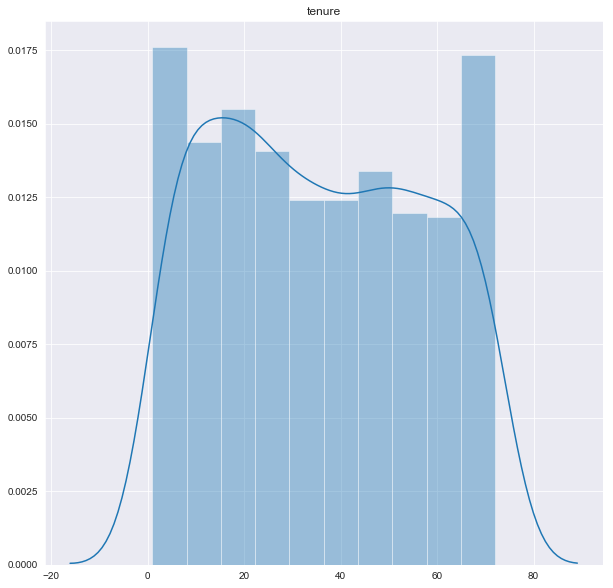

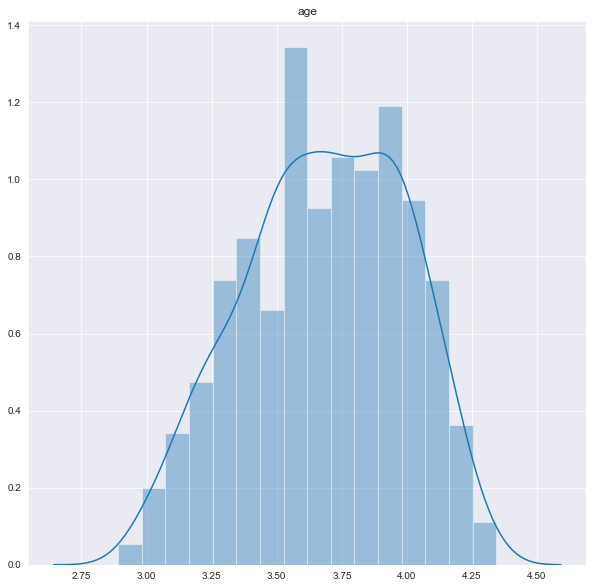

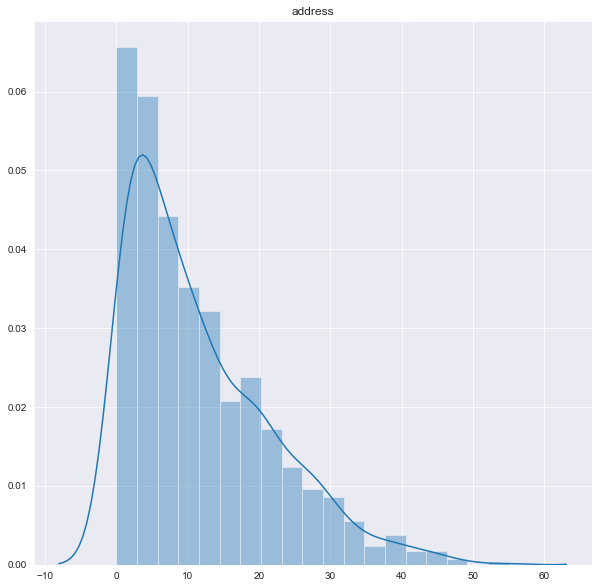

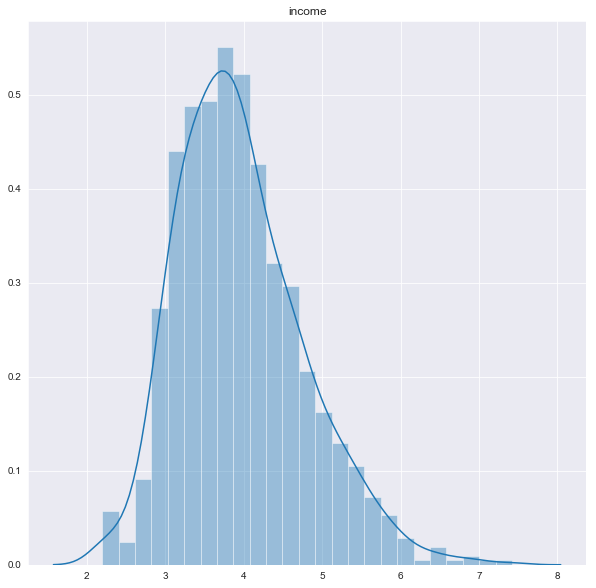

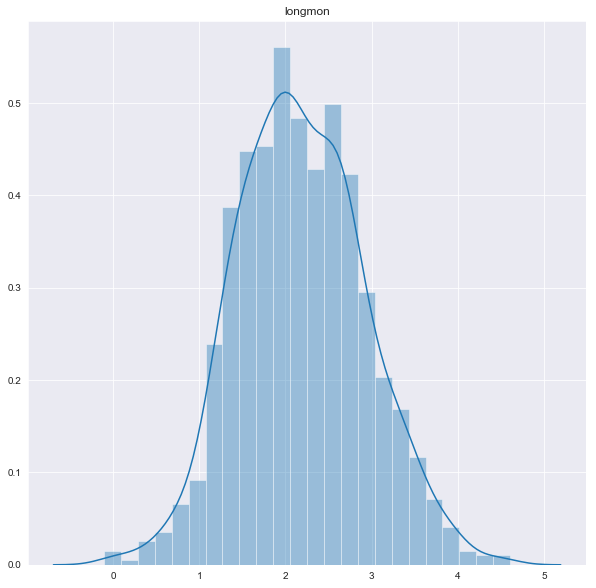

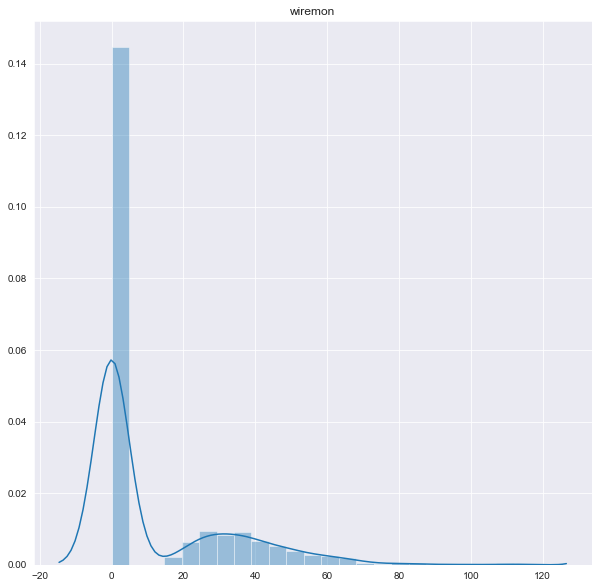

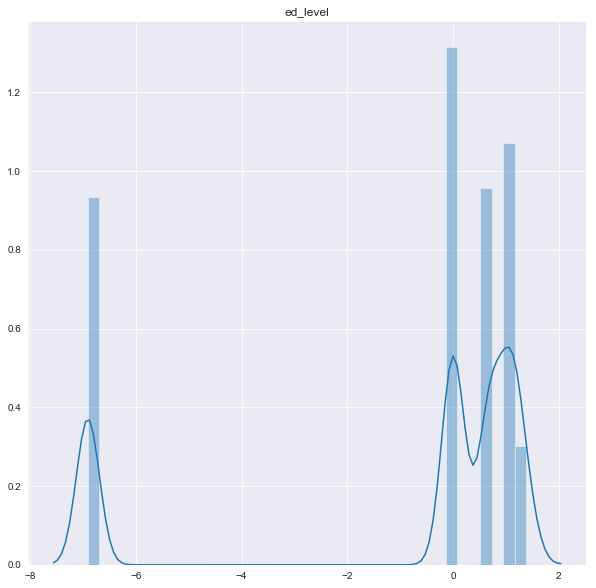

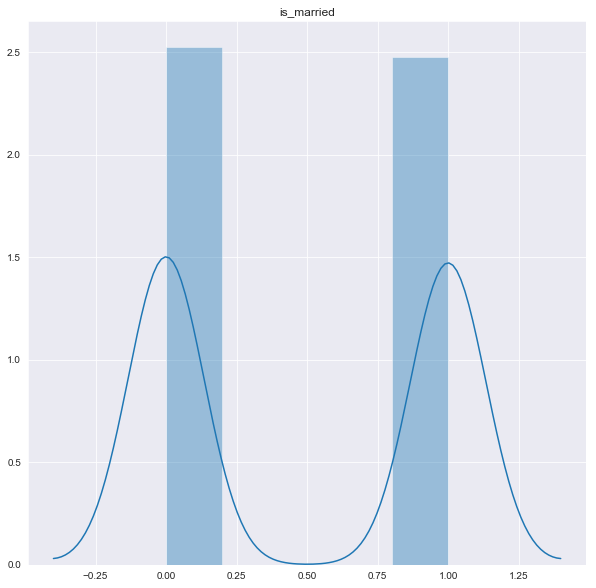

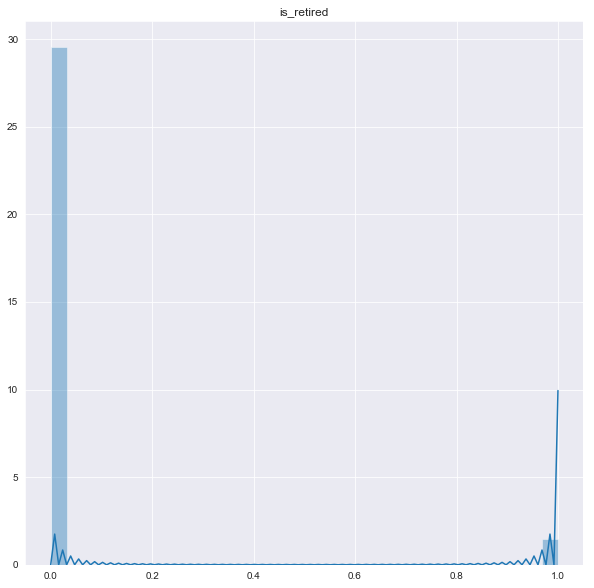

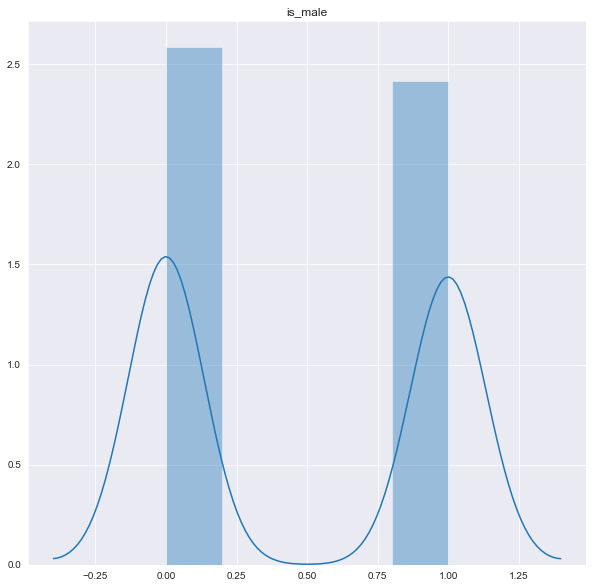

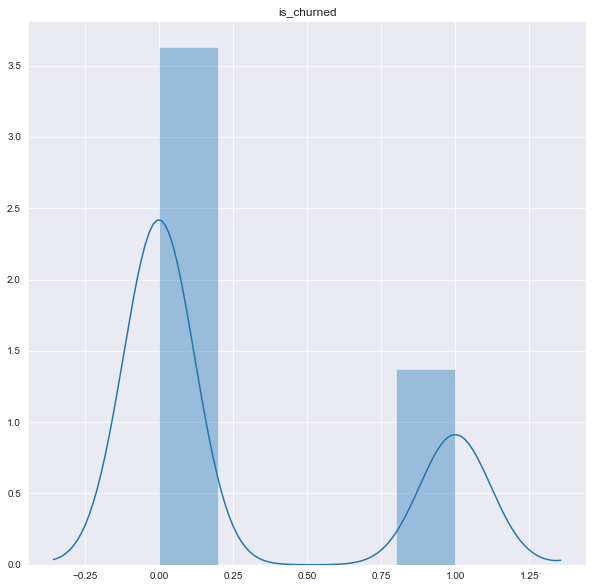

In [70]:
for col in data.columns:
    fig = plt.figure(figsize=(10, 10))
    plt.title(col)
    _ = sb.distplot(data[col].values)

In [113]:
cols = ['tenure', 'age', 'address', 'income', 'longmon']
scalers = {}
for col in cols:
    scaler = MinMaxScaler()
    data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    scalers[col] = scaler

> <font size=3> I used min-max normalization to map numeric variables into [0, 1] interval. From my previous experience I know that it works well on practice, but maybe it would worth to try standardization.
  <font>

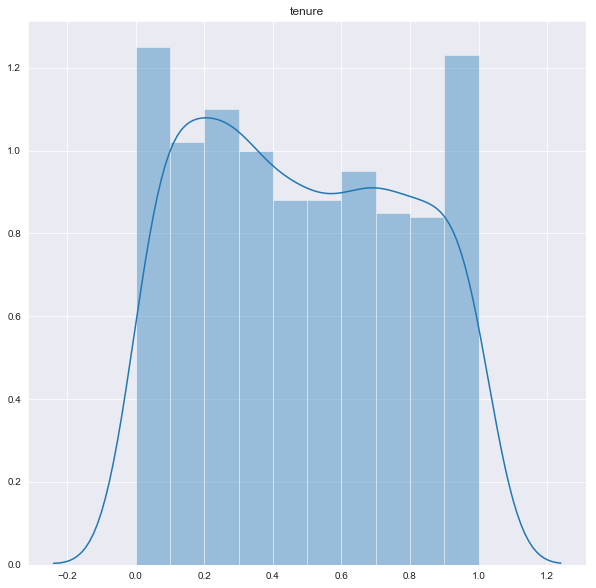

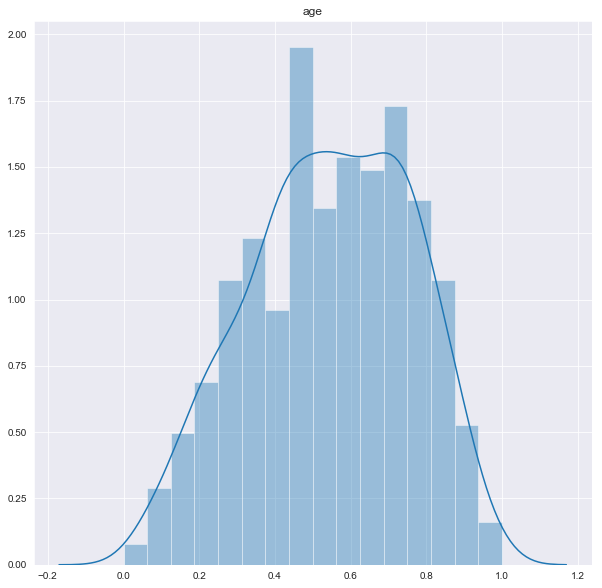

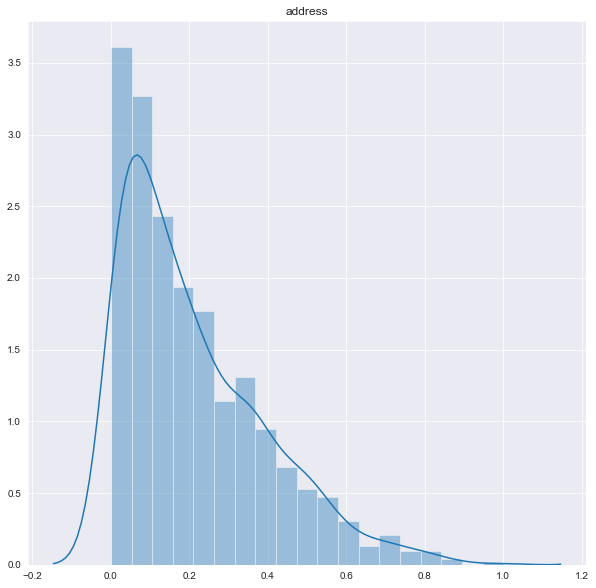

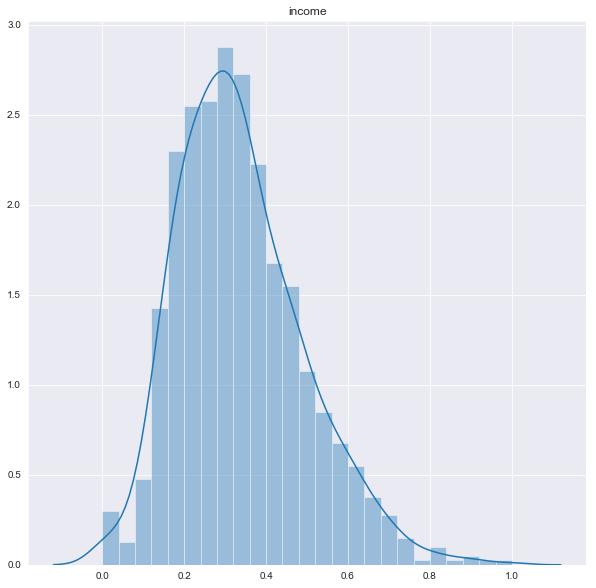

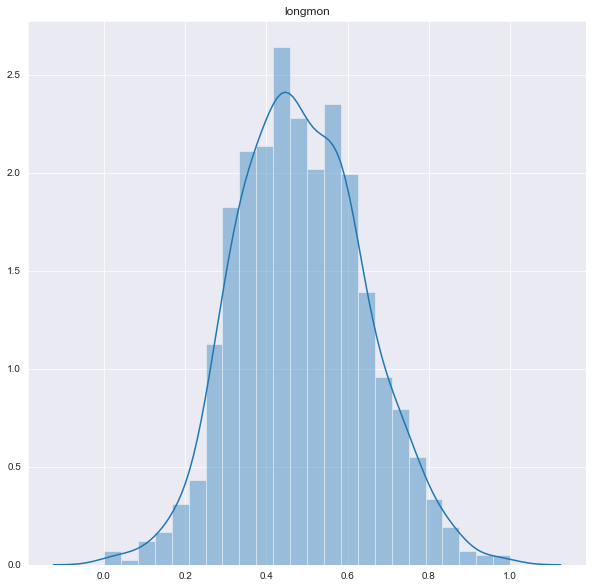

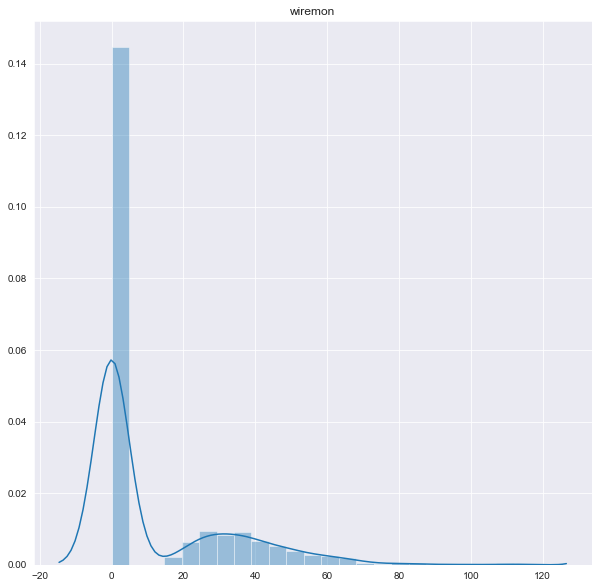

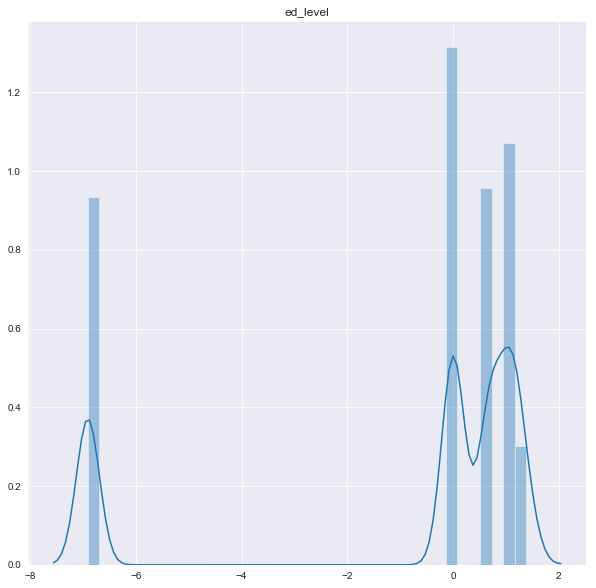

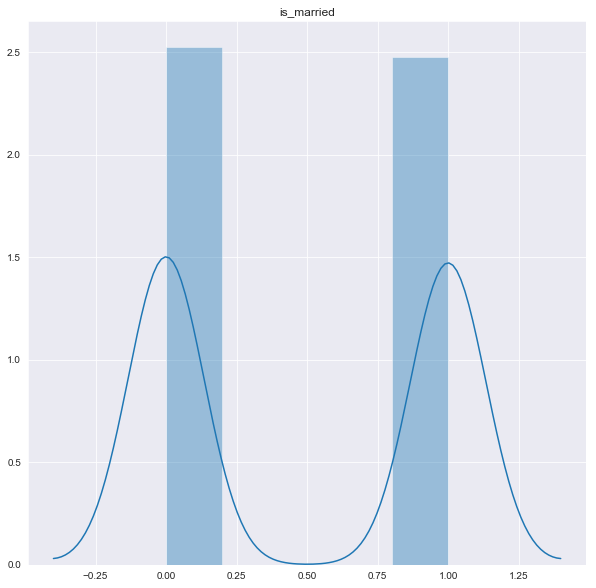

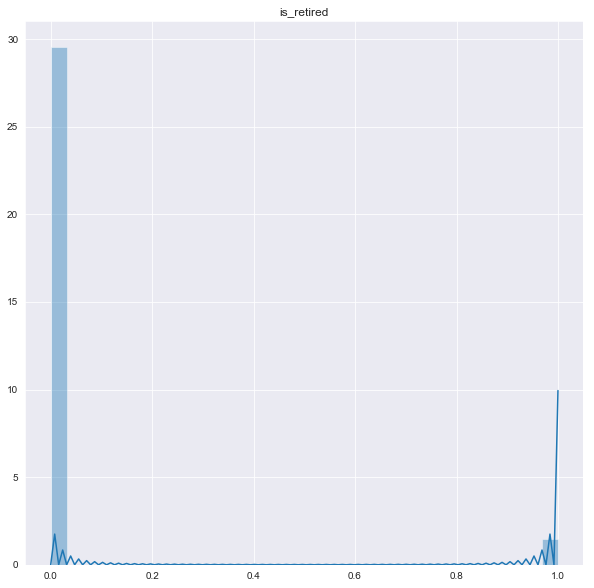

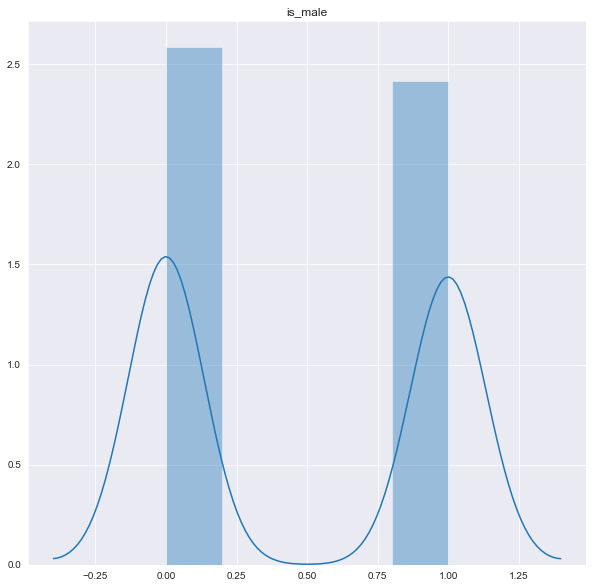

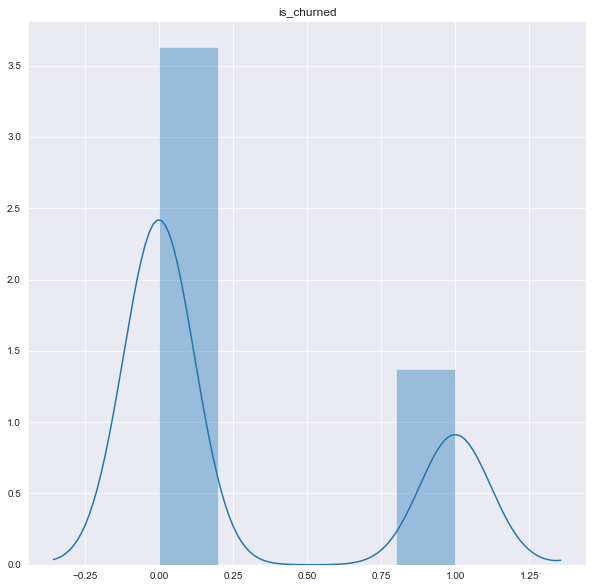

In [72]:
for col in data.columns:
    fig = plt.figure(figsize=(10, 10))
    plt.title(col)
    _ = sb.distplot(data[col].values)

> <font size=3> Now distribution of numeric variables looks more like normal, but some of the variables contain outliers, which can affect the following linear regression. <br><br> Also, we can observe that variable wiremon consists of two parts: kind of normal distribution and just zeros, so it makes sense to transform this variable into binary form (Did client use a wireless connection at all?). Of course, in this case, we'll lose some information, but for the first approach, it makes sense. Later we can try to include information about the duration of wireless network usage for those who used it at least once.
  <font>

In [114]:
data['used_wire'] = data['wiremon'].apply(lambda duration: 1 if duration > 0 else 0)
data = data.drop(columns=['wiremon'])

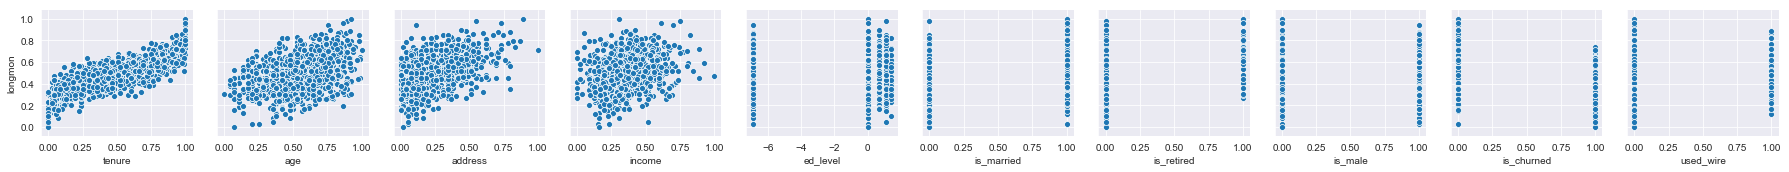

In [74]:
_ = sb.pairplot(data, x_vars=data.drop(columns=['longmon']).columns, y_vars=['longmon'])

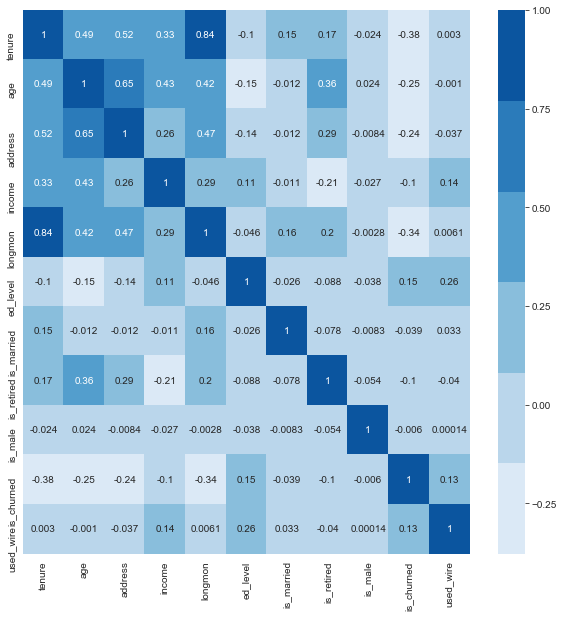

In [75]:
plt.figure(figsize=(10, 10))
_ = sb.heatmap(data.corr(), annot=True, cmap=sb.color_palette("Blues"))

> <font size=3>
    Finally, from the correlation matrix we can see that tenure and age are highly correlated, so we need to keep in mind that fact and try different models without either one or another feature.
  <font>

### Task 3: First model and education significance

In [115]:
x = data.iloc[:, data.columns != 'longmon']
intercept = pd.Series(np.ones(x.shape[0]), index=pd.Index(np.arange(1,1001,1)))
x = pd.concat([x, intercept], axis=1)
x = x.rename(columns={0: 'intercept'})

y = data['longmon']

model = sm.OLS(y, x)
result = model.fit()

summary = result.summary()
f_stat = float(summary.tables[0][2][3].data)
f_prob = float(summary.tables[0][3][3].data)
jb_stat = float(summary.tables[2][1][3].data)
jb_prob = float(summary.tables[2][2][3].data)

In [77]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     249.0
Date:                Tue, 11 Dec 2018   Prob (F-statistic):          4.76e-262
Time:                        22:16:58   Log-Likelihood:                 1068.6
No. Observations:                1000   AIC:                            -2115.
Df Residuals:                     989   BIC:                            -2061.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tenure         0.4129      0.011     35.948      0.000       0.390       0.435
age           -0.0274      0.019     -1.421      0.156      -0.065       0.010
address        0.0419      0.020      2.089      0.037       0.003       0.081
income         0.0357      0.022      1.610      0.108      -0.008       0.079
ed_level       0.0023      0.001      2.442      0.015       0.000       0.004
is_married     0.0151      0.005      2.774      0.006       0.004       0.026
is_retired     0.0536      0.015      3.550      0.000       0.024       0.083
is_male        0.0075      0.005      1.409      0.159      -0.003       0.018
is_churned    -0.0093      0.007     -1.423      0.155      -0.022       0.004
used_wire     -0.0022      0.006     -0.358      0.721      -0.014       0.010
intercept      0.2706      0.010     27.733      0.000       0.251       0.290
==============================================================================
Omnibus:                        2.310   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.315   Jarque-Bera (JB):                2.267
Skew:                          -0.060   Prob(JB):                        0.322
Kurtosis:                       3.199   Cond. No.                         33.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> <font size=3>
    Now we have the first model, and we have to inspect it. Let's start from looking on p-values for coefficients so that we can check their significance.
  <font>

In [78]:
alpha = 0.05
for name, pvalue in zip(result.pvalues.index, result.pvalues):
    if pvalue <= alpha:
        print('{}: {:.2f}'.format(name, pvalue))

print('\n{}: {:.2f}'.format('Education', result.pvalues['ed_level']))

tenure: 0.00
address: 0.04
ed_level: 0.01
is_married: 0.01
is_retired: 0.00
intercept: 0.00

Education: 0.01


> <font size=3>
    Okay, p-value suggests us that we can reject the hypothesis about coefficient insignificance ($H_0: \beta = 0$) for all variables listed above. Also, we see that we can say that about education too.
  <font>

In [79]:
print('F-test: statistic={:.2f}, p-value={:.2f}'.format(f_stat, f_prob))

F-test: statistic=249.00, p-value=0.00


> <font size=3>
   F-test or the test for general linear hypothesis helps us to understand if at least on coefficient doesn't equal to zero, so at least one feature has an impact on target variable. In our case p-value for this test equals to zero, so we can reject the hypothesis that all coefficients equal to zero.
  <font>

In [80]:
print('Jarque-Bera goodness-of-fit test: statistic={:.2f}, p-value={:.2f}'.format(jb_stat, jb_prob))

Jarque-Bera goodness-of-fit test: statistic=2.27, p-value=0.32


> <font size=3>
    Jarque-Bera test says us if we can or can't reject the hypothesis that residuals are normally distributed. In our case, we can't reject this hypothesis.
  <font>

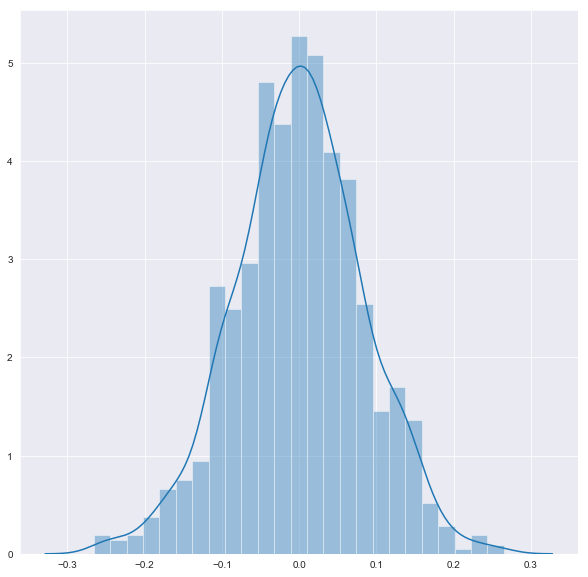

In [81]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = sb.distplot(result.resid.values)

> <font size=3> Also, we can visually inspect the distribution of residuals and check that it's very similar to normal.
  <font>

### Task 4: Economic interpretation

> <font size=3>
     I'm not sure what is meant by economic interpretation. I explained a lot about the education variable and why I chose to create a single ordinal variable instead of a couple of dummy variables. It's worth to note that I applied logarithm and scaling to this variable to make it more sensitive to the users without education at all. However, it's economic interpretation should be still the same. I can say the same about variables address and is_retired (I only scaled address variable, but it shouldn't make a significant impact on interpretability)
  <font>

### Task 5: CI

> <font size=3>
    First of all, I want to note that I performed the test for the normality of the residuals in the previous task, the test suggests that we can't reject the hypothesis that residuals are normally distributed. <br><br>
Now let's examine CIs for variables address and income. 
  <font>

In [82]:
conf_1, conf_2 = result.conf_int().loc['address', :]
p_value = result.pvalues['address']
print('Variable address\n  conf interval: [{:.4f}, {:.4f}] | p-value: {:.4f}'.format(conf_1, conf_2, p_value))

p_value = result.pvalues['income']
conf_1, conf_2 =result.conf_int().loc['income', :]
print('Variable income\n  conf interval: [{:.4f}, {:.4f}] | p-value: {:.4f}'.format(conf_1, conf_2, p_value))

Variable address
  conf interval: [0.0025, 0.0812] | p-value: 0.0370
Variable income
  conf interval: [-0.0078, 0.0791] | p-value: 0.1077


> <font size=3>
    So we see that with the 95% probability address variable lies in the interval, which excludes zero, and p-value supports this hypothesis (it says that we can reject the hypothesis about address insignificance). Moreover, such confidence interval means that the probability of address variable to be insignificant is less than 2.5%. On the other hand, the income variable with 95% probability lies in the interval, which includes zero, and p-value tells us that we can't reject the hypothesis about income insignificance. <br><br>
    Economically it means that most likely address has an impact on the long distance calls and income has not.
  <font>

### Task 6: Best model

> <font size=3> There is no method in Statsmodels or any other Python package for the forward model selection, so I used one of the implementations, which I found with the help of Google. I hope it isn't inconsistent with the values of academic integrity. <br><br>
    Link to the source of the code: <br>
    https://planspace.org/20150423-forward_selection_with_statsmodels/ <br><br>
    Of course, I've checked the validity of the code and I'm able to explain how it works: <br>
    We start with the simplest model, which means that has only one regressor and intercept, we check all ten different models (because we have ten regressors) and find the best one, then we select the most important regressor among all based on the value of $R^2$ score. On the next step we do the same, but now we have a bit more complex model, which consists of two regressors and intercept. Of course, one of these regressors is fixed from the previous step, and the second one is selected among different regressors, which are remained. We continue this process while we still have remaining regressors or we can get the higher score.
  <font>

In [116]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model, selected

In [117]:
best_model, selected_regressors = forward_selected(data, 'longmon')
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     276.9
Date:                Tue, 11 Dec 2018   Prob (F-statistic):          2.96e-263
Time:                        22:41:31   Log-Likelihood:                 1068.5
No. Observations:                1000   AIC:                            -2117.
Df Residuals:                     990   BIC:                            -2068.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2703      0.010     27.798      0.000       0.251       0.289
tenure         0.4128      0.011     35.968      0.000       0.390       0.435
is_retired     0.0535      0.015      3.545      0.000       0.024       0.083
ed_level       0.0022      0.001      2.425      0.015       0.000       0.004
is_married     0.0150      0.005      2.763      0.006       0.004       0.026
address        0.0421      0.020      2.101      0.036       0.003       0.081
is_churned    -0.0095      0.006     -1.475      0.141      -0.022       0.003
is_male        0.0075      0.005      1.404      0.161      -0.003       0.018
income         0.0348      0.022      1.582      0.114      -0.008       0.078
age           -0.0274      0.019     -1.424      0.155      -0.065       0.010
==============================================================================
Omnibus:                        2.208   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.332   Jarque-Bera (JB):                2.155
Skew:                          -0.058   Prob(JB):                        0.340
Kurtosis:                       3.195   Cond. No.                         33.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
alpha = 0.05

print('Regressors selected by forward selection (based on R^2) and which are also significant by p-value:')
for name, pvalue in zip(best_model.pvalues.index, best_model.pvalues):
    for regressor in selected_regressors:
        if pvalue <= alpha and name == regressor:
            print('{}: {:.2f}'.format(name, pvalue))

print('\nRegressors selected by forward selection (based on R^2 only):')
for name, pvalue in zip(best_model.pvalues.index, best_model.pvalues):
    for regressor in selected_regressors:
        if pvalue > alpha and name == regressor:
            print('{}: {:.2f}'.format(name, pvalue))



Regressors selected by forward selection (based on R^2) and which are also significant by p-value:
tenure: 0.00
is_retired: 0.00
ed_level: 0.02
is_married: 0.01
address: 0.04

Regressors selected by forward selection (based on R^2 only):
is_churned: 0.14
is_male: 0.16
income: 0.11
age: 0.15


> <font size=3>
    Ok, we see that the coefficient of determination is approx the same as in our initial model as well as variables which are selected by p-value. But forward selection process reveals that there are four more important features. Also, it seems that the variable used_wire (a binary feature which is true if a user used a wireless connection at least once) isn't significant based on both forward selection and p-value. So the model without this variable is the smallest model with good explanatory power.
  <font>

### Task 7: Inspecting outliers

In [86]:
from statsmodels.stats.outliers_influence import OLSInfluence
outliers = OLSInfluence(best_model)
cooks_dist = outliers.summary_frame()[['cooks_d']]
leverage = outliers.summary_frame()[['hat_diag']]

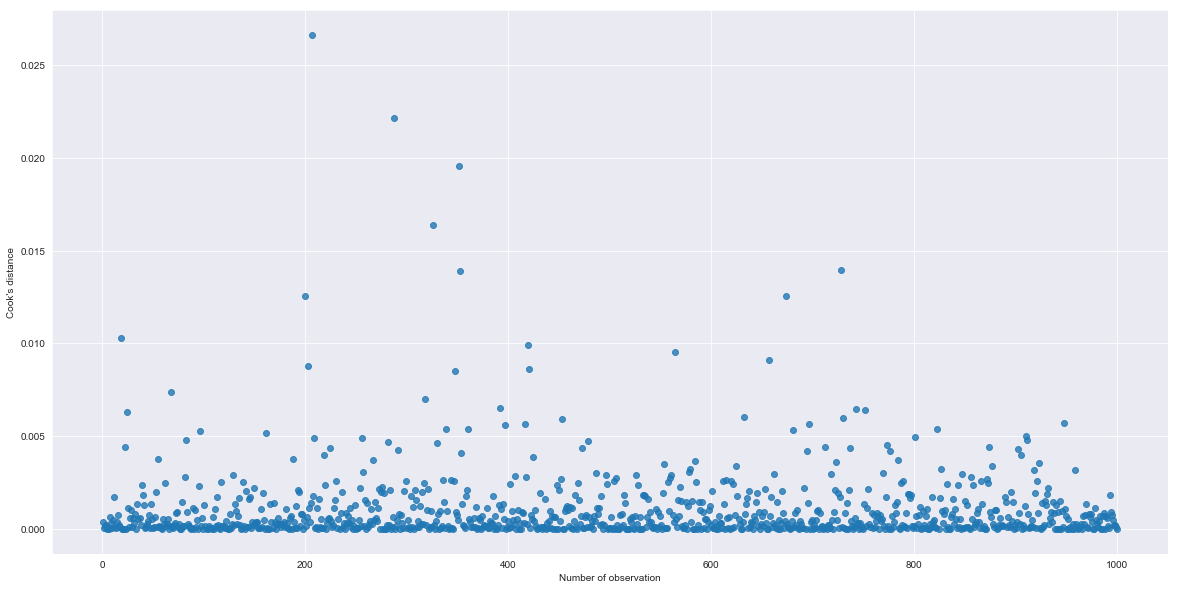

In [87]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel('Number of observation')
ax.set_ylabel('Cook\'s distance')
_ = sb.regplot(np.arange(1, data.shape[0] + 1, 1), cooks_dist.values.reshape(-1), fit_reg=False)

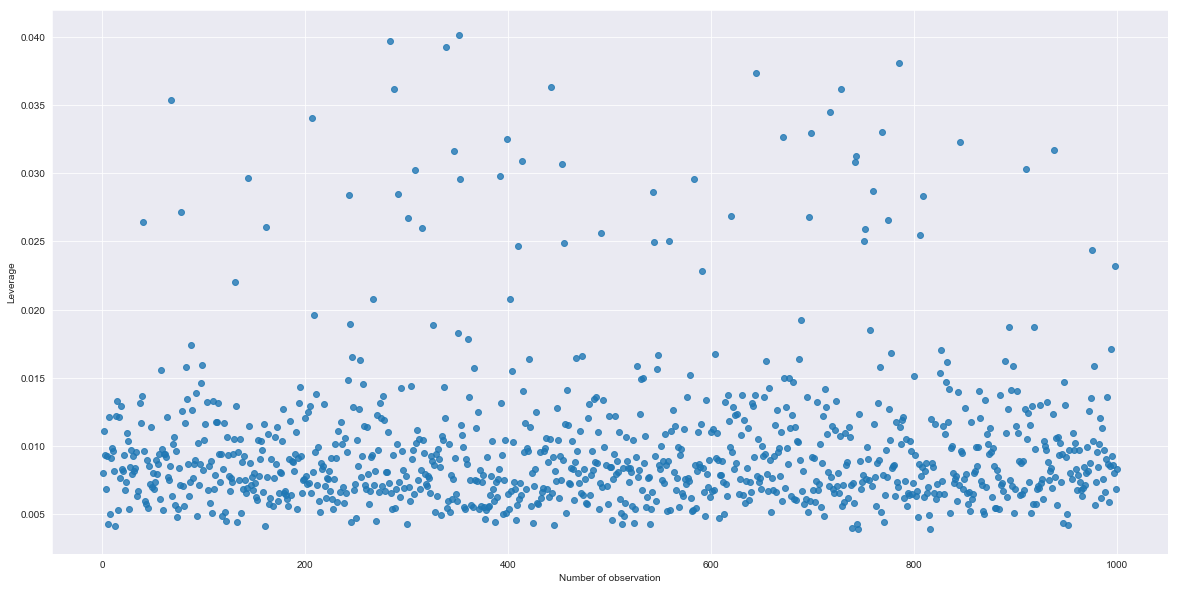

In [88]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel('Number of observation')
ax.set_ylabel('Leverage')
_ = sb.regplot(np.arange(1, data.shape[0] + 1, 1), leverage.values.reshape(-1), fit_reg=False)

> <font size=3> We can set some threshold on the highest possible value of the leverage and inspect all data samples for which the value of the leverage exceeds this threshold.
  <font>

In [89]:
threshold = 0.02
outliers = data.loc[leverage[leverage.hat_diag > threshold].index, :]
average = data.loc[leverage[leverage.hat_diag < threshold].index, :]

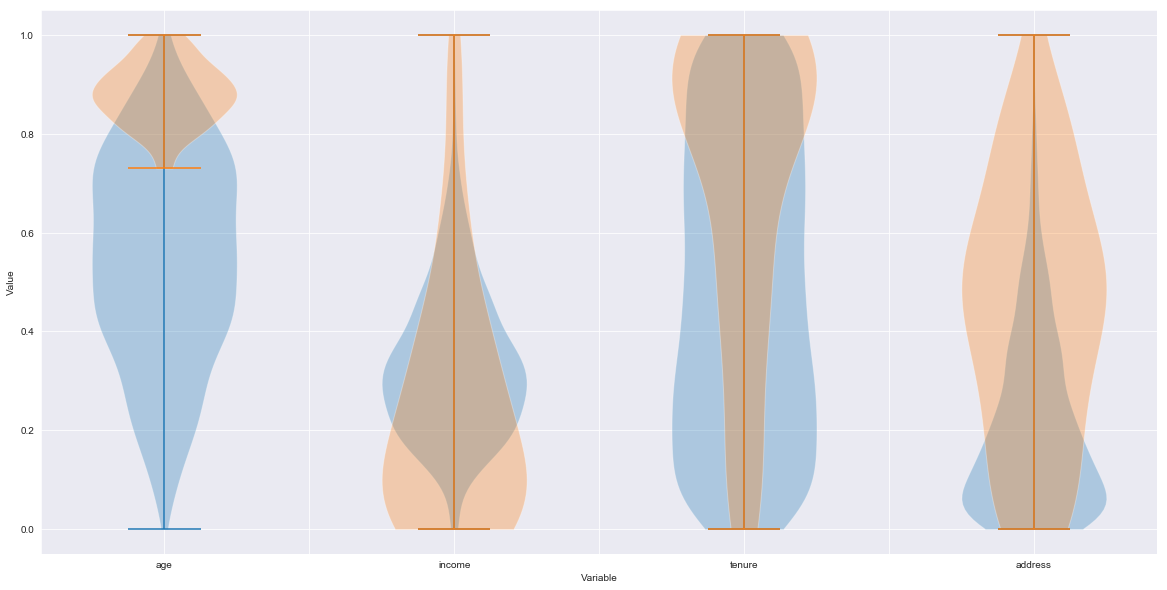

In [90]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel('Variable')
ax.set_ylabel('Value')
_ = ax.violinplot(data[['age', 'income', 'tenure', 'address']].values)
_ = ax.violinplot(outliers[['age', 'income', 'tenure', 'address']].values)
_ = ax.set_xticklabels(['age', 'age', '  ','income', '  ', 'tenure', '  ', 'address'])




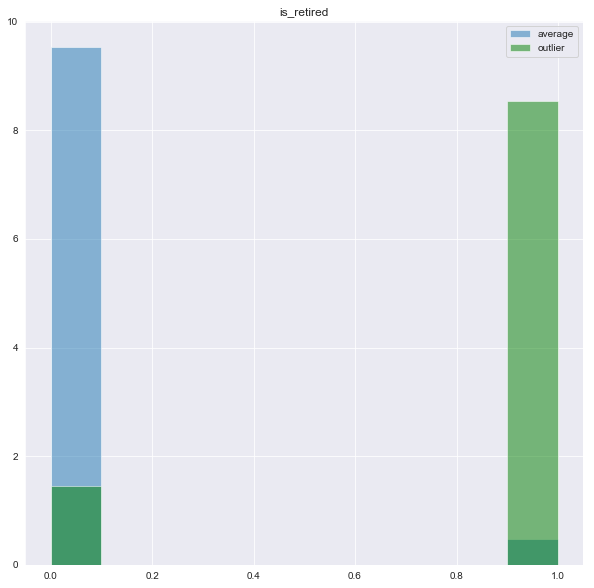

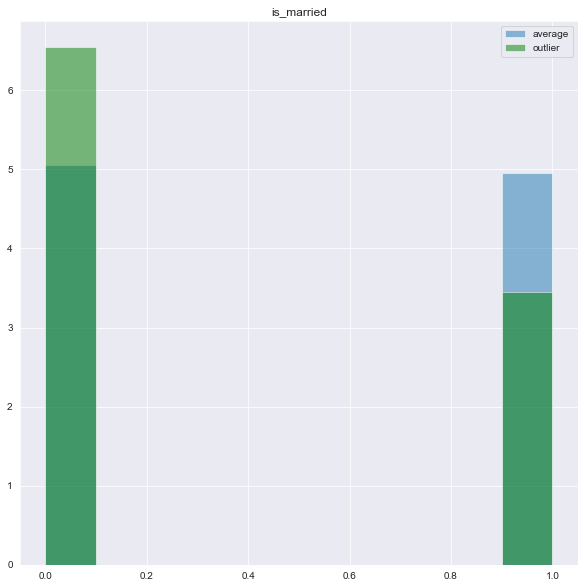

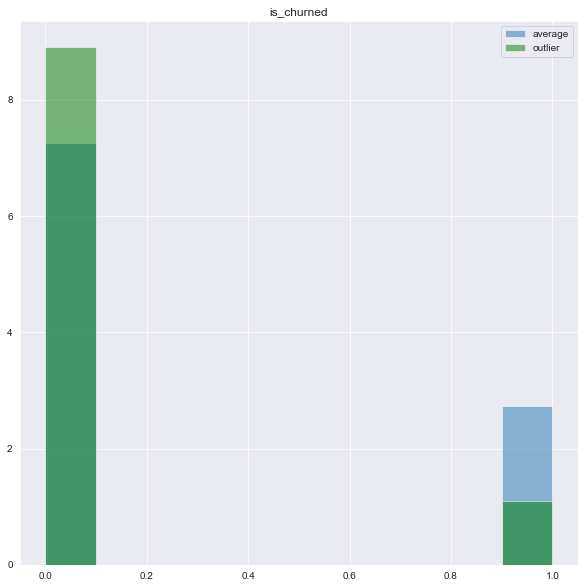

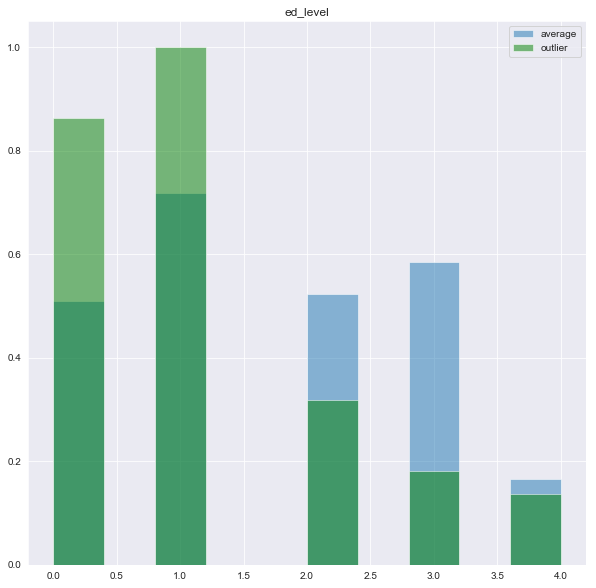

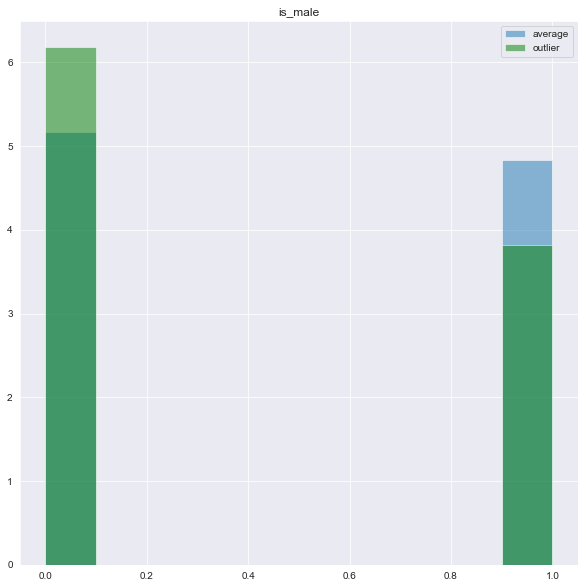

In [91]:
for col in ['is_retired', 'is_married', 'is_churned', 'ed_level', 'is_male']:
    if col == 'ed_level':
        fig = plt.figure(figsize=(10, 10))
        plt.title(col)
        _ = plt.hist(np.exp(data[col].values), normed=True, alpha=0.5, label='average')
        _ = plt.hist(np.exp(outliers[col].values), normed=True, alpha=0.5, color='green', label='outlier')
        _ = plt.legend()
    else:
        fig = plt.figure(figsize=(10, 10))
        plt.title(col)
        _ = plt.hist(data[col].values, normed=True, alpha=0.5, label='average')
        _ = plt.hist(outliers[col].values, normed=True, alpha=0.5, color='green', label='outlier')
        _ = plt.legend()

> <font size=3>
    Histograms for categorical and one ordinal variable are not so helpful to understand the difference in distributions, but violin plots for numeric variables are extremely illustrative. Outliers are distributed in the tails of the original distributions.
  <font>

### Task 8: Dealing with missing data 

In [92]:
random_id = np.random.randint(1, data.shape[0], 5)
data_with_na = data.copy()
data_with_na.set_value(random_id, 'address', None)
data_with_na.loc[data_with_na.address.isnull()]

tenure       age  address    income   longmon  ed_level  is_married  \
7    0.619718  0.138064      NaN  0.143077  0.529442  0.001000           1   
229  0.070423  0.417032      NaN  0.203139  0.406186  0.693647           0   
629  0.957746  0.893939      NaN  0.324491  0.688931  0.001000           1   
745  0.436620  0.495749      NaN  0.303880  0.536153  0.001000           0   
766  0.183099  0.549389      NaN  0.725601  0.416380  1.386544           0   

     is_retired  is_male  is_churned  used_wire  
7             0        0           1          0  
229           0        1           1          1  
629           0        1           0          0  
745           0        1           0          0  
766           0        0           1          1

> <font size=3>
    There are a couple of common approaches to deal with missing data. We can simply drop such rows. Using this approach we lose some probably useful information, but if they're just a couple of data samples with missing data, it could be not so painful. Also, we can fill missing values with the value of some statistic (for example mean or median). In this case, we save a lot of information, but we can harm the distribution of the variable a bit, so it won't represent the real world anymore (but it's very unlikely). And the third way is to perform regression, so that's how we can get the most robust values to fill in.
   <font>

In [93]:
data_without_na = data_with_na.dropna()
print('Our dataset became smaller, now there are only {} rows.'.format(data_without_na.shape[0]))

Our dataset became smaller, now there are only 995 rows.


In [94]:
data_without_na = data_with_na.fillna(value=data_with_na.address.mean())
data_without_na.loc[random_id]

tenure       age   address    income   longmon  ed_level  is_married  \
7    0.619718  0.138064  0.209849  0.143077  0.529442  0.001000           1   
629  0.957746  0.893939  0.209849  0.324491  0.688931  0.001000           1   
745  0.436620  0.495749  0.209849  0.303880  0.536153  0.001000           0   
229  0.070423  0.417032  0.209849  0.203139  0.406186  0.693647           0   
766  0.183099  0.549389  0.209849  0.725601  0.416380  1.386544           0   

     is_retired  is_male  is_churned  used_wire  
7             0        0           1          0  
629           0        1           0          0  
745           0        1           0          0  
229           0        1           1          1  
766           0        0           1          1

> <font size=3>
In the case of a binary variable, the situation is much simpler. We simply can sample from the empirical distribution of the given variable, which is pretty simple to get, we just need to count relative frequencies for each value and then simulate it.
  <font>

### Task 9: GLS

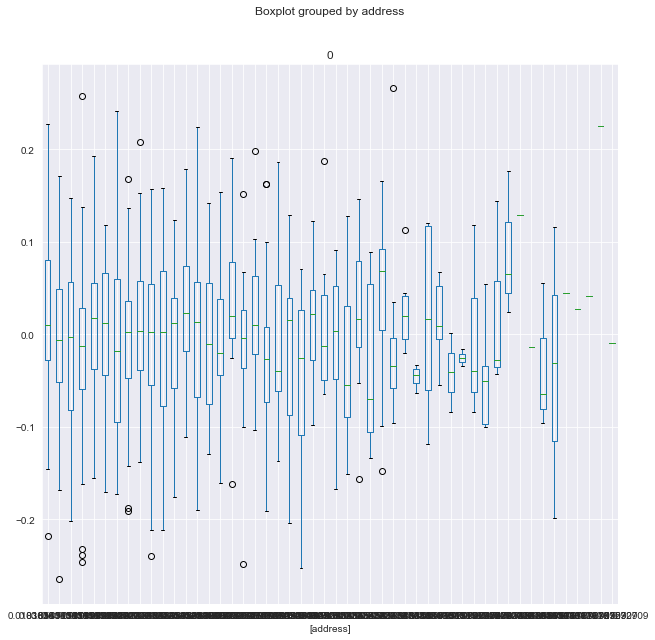

In [153]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = pd.concat([x.address, best_model.resid], axis=1).boxplot(by='address', ax=ax)

> <font size=3>
    We see that there exist some difference in the variance of the residuals between different values of the address variable, but it's better to check it with a help of the Bartlett's test.
  <font>

In [189]:
groups = []
for g in pd.concat([x.address, best_model.resid], axis=1).groupby('address'):
    group = list(g[1][0].values)
    if len(group) > 1:
        groups.append(group)


In [190]:
from scipy.stats import bartlett
bartlett(*groups)

BartlettResult(statistic=41.67342030055553, pvalue=0.4851857971882389)

> <font size=3>
    Bartlett's test tells us that we can't reject the hypothesis that variances between those different groups are different. That's why it's not so reasonable to compute FGLS estimation, because it's actually useful in the cases when there are different variances.
  <font>

### Task 10: White estimator

In [121]:
model = sm.OLS(y, x)
result = model.fit(cov_type='HC0')

summary = result.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     230.0
Date:                Tue, 11 Dec 2018   Prob (F-statistic):          4.90e-250
Time:                        22:52:17   Log-Likelihood:                 1068.6
No. Observations:                1000   AIC:                            -2115.
Df Residuals:                     989   BIC:                            -2061.
Df Model:                          10                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tenure         0.4129      0.011     36.388      0.000       0.391       0.435
age           -0.0274      0.019     -1.422      0.155      -0.065       0.010
address        0.0419      0.020      2.061      0.039       0.002       0.082
income         0.0357      0.022      1.600      0.110      -0.008       0.079
ed_level       0.0023      0.001      2.300      0.021       0.000       0.004
is_married     0.0151      0.005      2.763      0.006       0.004       0.026
is_retired     0.0536      0.016      3.375      0.001       0.022       0.085
is_male        0.0075      0.005      1.426      0.154      -0.003       0.018
is_churned    -0.0093      0.006     -1.449      0.147      -0.022       0.003
used_wire     -0.0022      0.006     -0.360      0.719      -0.014       0.010
intercept      0.2706      0.010     28.210      0.000       0.252       0.289
==============================================================================
Omnibus:                        2.310   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.315   Jarque-Bera (JB):                2.267
Skew:                          -0.060   Prob(JB):                        0.322
Kurtosis:                       3.199   Cond. No.                         33.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

> <font size=3>
    Here we perforemed simple OLS, but with better estimation of the variance of the parameters, so that we can obtain more robust confidence intervals for coeficients and also perform test on significance more precisely (we can see a small diference in the CIs and p-values between this model and the original one). It's helpful under the heteroskedasticity, because then it has an impact on the variance of the OLS solution.
  <font>

### Problem 5: Further issues

### Task 1: Shifted target variable

> <font size=3>
    Let's generate some data to perform a couple of experiments. We'll sample 2 regressors from $N(10, 9)$ and we'll get target variable as: <br><br><center>$y = 3x + 2x + 1 + \epsilon$, where $\epsilon \sim N(0, 1)$</center>
  <font>

In [95]:
x = np.random.normal(10, 3, [100, 2])
eps = np.random.normal(0, 1)
y = 3*x[:, 0] + 2*x[:, 1] + 1 + eps

In [96]:
model = sm.OLS(y, x)
result = model.fit()
summary = result.summary()
r2 = float(summary.tables[0][0][3].data)
print('R^2: {:.2f}'.format(r2))

R^2: 1.00


> <font size=3>
    Ok, we got the perfect coefficient of determination. Now let's try to shift our target variable.
  <font>

In [97]:
y_shifted = y + 10
model = sm.OLS(y_shifted, x)
result = model.fit()
summary = result.summary()
r2 = float(summary.tables[0][0][3].data)
print('R^2: {:.2f}'.format(r2))

R^2: 1.00


In [98]:
y_shifted = y - 10
model = sm.OLS(y_shifted, x)
result = model.fit()
summary = result.summary()
r2 = float(summary.tables[0][0][3].data)
print('R^2: {:.2f}'.format(r2))

R^2: 1.00


> <font size=3>
    Oh, now we have completely different target variable, but coefficient of determination is still the same. Actually, it's easy to explain why it's happening in that way. <br><br>
    We know that: <br><br><center>$R^2 = 1 - \frac {\sum (y_i - \hat y_i)^2} {\sum (y_i - \overline y)^2}$ </center><br><br>
    Also we know that: <br><br><center>$\hat y^* = X\beta = X(X^TX)^{-1}X^Ty^* = X(X^TX)^{-1}X^T(y + \vec {10}) = \hat y + X(X^TX)^{-1}X^T \vec {10} = \hat y + I\vec {10} = \hat y + \vec {10}$ </center><br><br>
    So that: <center>$(R^2)^* = 1 - \frac {\sum (y_i^* - \hat y_i^*)^2} {\sum (y_i^* - \overline {y^*})^2} = 1 - \frac {\sum (y_i + 10 - (\hat y_i + 10))^2} {\sum (y_i + 10 - (\overline {y} + 10))^2} = 1 - \frac {\sum (y_i - \hat y_i)^2} {\sum (y_i - \overline y)^2} = R^2$ </center><br><br>
    Also, it's easy to see that this shift influences only bias coefficient: <br><br>
    <center> $\beta^* = (X^TX)^{-1}X^Ty^* = (X^TX)^{-1}X^T(y + \vec {10}) = \beta + (X^TX)^{-1}X^T\vec{10}$, where </center><br><br>
    $(X^TX)^{-1}X^T\vec{10}$ is simply regression of the constant value, so: <br><br><center> $\beta^* = \beta + \begin{pmatrix} 10 \\0 \\ ... \\ 0 \end{pmatrix}$ </center><br>
  <font>

### Task 2: Shift regressors

> <font size=3>
    Now let's try to shift some regressors and see how it will influence the coefficient of determination.
  <font>

In [107]:
x = np.random.normal(10, 3, [100, 2])
eps = np.random.normal(0, 1)
y = 3*x[:, 0] + 2*x[:, 1] + 1 + eps

In [108]:
model = sm.OLS(y, x)
result = model.fit()
summary = result.summary()
r2 = float(summary.tables[0][0][3].data)
print('R^2: {:.2f}'.format(r2))

x[:, 0] = x[:, 0] + 10
model = sm.OLS(y, x)
result = model.fit()
summary = result.summary()
r2 = float(summary.tables[0][0][3].data)
print('R^2: {:.2f}'.format(r2))

R^2: 1.00
R^2: 1.00


> <font size=3> 
    So the coefficient of determination is still the same. Let's explain: <br><br>
    <center> $y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n + \epsilon$ - our model </center><br><br>
    <center> $x_i^* = x_i + a$ - shifted regressor </center><br><br>
    <center> then </center><br><br>
    <center> $y = \beta_0 + \beta_1x_1 + ... + \beta_i(x_i + a) + ... + \beta_nx_n + \epsilon = \beta_0 + \beta_ia + \beta_1x_1 + ... + \beta_nx_n + \epsilon$ </center><br><br>
    <center> or </center><br><br>
    <center> $y - \beta_ia = \beta_0 + \beta_1x_1 + ... + \beta_nx_n + \epsilon$ </center><br><br>
    <center> so we got the same as in the previous case, just the shift of the target </center><br><br>
    <center>$y^* = y - \beta_ia$</center><br><br>
    <center>so that's why the coefficient is the same even after regressor transformation.</center>
  <font>
   

### Task 3: Demeaned regressors & target variable

> <font size=3>
    It's often helpful to normalize your data before performing linear regression. Actually I did it in the previous problem, but we need to be sure that those transformations won't influence the coefficient of determinataion, because we rely on it as a good indicator of the quality of our model.
  <font>

In [101]:
x = np.random.normal(10, 3, [100, 2])
eps = np.random.normal(0, 1)
y = 3*x[:, 0] + 2*x[:, 1] + 1 + eps

In [102]:
# mean substracting
x[:, 0] = x[:, 0] - x[:, 0].mean()
x[:, 1] = x[:, 1] - x[:, 1].mean()
y = y - y.mean()

In [103]:
model = sm.OLS(y, x)
result = model.fit()
summary = result.summary()
r2 = float(summary.tables[0][0][3].data)
print('R^2 on scaled data: {:.2f}'.format(r2))

R^2 on scaled data: 1.00


> <font size=3>
    Empirically we see that the coefficient of the determination is still the same, which is good, but let's show it theoretically. Actually it's pretty similar to the previous case: <br><br> 
    <center> $y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n + \epsilon$ - our model </center><br><br>
    <center> $\forall i: x_i^* = x_i - \overline {x_i}$ - demeaned regressors </center><br><br>
    <center> $y^*  = y - \overline y$ - demeaned target</center><br><br>
    <center> then </center><br><br>
    <center> $y - \overline y = \beta_0 + \beta_1(x_1 - \overline {x_1}) + ... + \beta_n(x_n - \overline {x_n}) + \epsilon = \beta_0 - \beta_1 \overline {x_1} + ... - \beta_n \overline {x_n} + \beta_1x_1 + ... + \beta_nx_n + \epsilon$ </center><br><br>
    <center> or </center><br><br>
    <center> $y - \overline y + \beta_1 \overline {x_1} + ... + \beta_n \overline {x_n} = \beta_0 + \beta_1x_1 + ... + \beta_nx_n + \epsilon$ </center><br><br>
    <center> so we got the same as in the previous case, just the shift of the target </center><br><br>
    <center>$y^* = y - \overline y + \beta_1 \overline {x_1} + ... + \beta_n \overline {x_n}$</center><br><br>
    <center>so that's why the coefficient is the same even after regressor transformation.</center>
  <font>